In [ ]:
!pip install udocker
!udocker --allow-root install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.6/119.6 kB 9.4 MB/s eta 0:00:00
Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.17
Info: searching for udockertools >= 1.2.11
Info: installing udockertools 1.2.11
Info: installation of udockertools successful


In [ ]:
import subprocess

command = "udocker --allow-root install && udocker --allow-root run -p 6379:6379 -i -t --rm falkordb/falkordb:edge"
process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [ ]:
!pip install --quiet langchain langchain_groq langchain_community langsmith langchain-openai langchain-groq langchain-experimental langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.7 MB/s eta 0:00:00


In [ ]:
!pip install --quiet falkordb redis

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 15.3 MB/s eta 0:00:00


In [ ]:
from langchain.chains import FalkorDBQAChain
from langchain_community.graphs import FalkorDBGraph
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq

In [ ]:
graph = FalkorDBGraph(database="movies")

In [ ]:
graph.query(
    """
    CREATE
        (al:Person {name: 'Al Pacino', birthDate: '1940-04-25'}),
        (robert:Person {name: 'Robert De Niro', birthDate: '1943-08-17'}),
        (tom:Person {name: 'Tom Cruise', birthDate: '1962-07-3'}),
        (val:Person {name: 'Val Kilmer', birthDate: '1959-12-31'}),
        (anthony:Person {name: 'Anthony Edwards', birthDate: '1962-7-19'}),
        (meg:Person {name: 'Meg Ryan', birthDate: '1961-11-19'}),

        (god1:Movie {title: 'The Godfather'}),
        (god2:Movie {title: 'The Godfather: Part II'}),
        (god3:Movie {title: 'The Godfather Coda: The Death of Michael Corleone'}),
        (top:Movie {title: 'Top Gun'}),

        (al)-[:ACTED_IN]->(god1),
        (al)-[:ACTED_IN]->(god2),
        (al)-[:ACTED_IN]->(god3),
        (robert)-[:ACTED_IN]->(god2),
        (tom)-[:ACTED_IN]->(top),
        (val)-[:ACTED_IN]->(top),
        (anthony)-[:ACTED_IN]->(top),
        (meg)-[:ACTED_IN]->(top)
"""
)

[]

In [ ]:
graph.refresh_schema()
print(graph.schema)

import os

Node properties: [[OrderedDict([('label', 'Person'), ('keys', ['name', 'birthDate'])])], [OrderedDict([('label', 'Movie'), ('keys', ['title'])])]]
Relationships properties: [[OrderedDict([('types', 'ACTED_IN'), ('keys', [])])]]
Relationships: [[OrderedDict([('end', 'Movie'), ('start', 'Person'), ('type', 'ACTED_IN')])]]



In [ ]:
GROQ_API_KEY=#GROQ_API_KEY
os.environ["GROQ_API_KEY"]=GROQ_API_KEY

In [ ]:
os.environ["OPENAI_API_KEY"] = #OPENAI_API_KEY

In [ ]:
llm=ChatGroq(temperature=0, model_name="mixtral-8x7b-32768")

In [ ]:
chain = FalkorDBQAChain.from_llm(ChatGroq(temperature=0, model_name="mixtral-8x7b-32768"), graph=graph, verbose=True, allow_dangerous_requests=True) # Setting allow_dangerous_requests to True

In [ ]:
chain.run("Who played in Top Gun?")

<ipython-input-19-982638b25926>:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  chain.run("Who played in Top Gun?")




> Entering new FalkorDBQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
WHERE m.title = 'Top Gun'
RETURN p.name
Full Context:
[['Tom Cruise'], ['Val Kilmer'], ['Anthony Edwards'], ['Meg Ryan']]

> Finished chain.


'Tom Cruise, Val Kilmer, and Anthony Edwards all played in Top Gun. Interestingly, Meg Ryan was also in the movie, although her role might not be as prominent in your memory.'

In [ ]:
%pip install --upgrade --quiet  langchain langchain-community langchain-openai langchain-experimental neo4j langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 4.9 MB/s eta 0:00:00


In [ ]:
import os
from operator import add

import re
import ast
import getpass
from typing import List, Dict, Literal, Annotated
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# from langchain_community.graphs import Neo4jGraph
# from langchain_community.vectorstores import Neo4jVector
# from langchain_community.vectorstores import FalkorDBVector

from langchain.chains import FalkorDBQAChain
from langchain_community.graphs import FalkorDBGraph

from pydantic import BaseModel, Field

In [ ]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str
    analysis: str
    previous_actions: List[str]

class OverallState(TypedDict):
    question: str
    rational_plan: str
    notebook: str
    previous_actions: Annotated[List[str], add]
    # check_atomic_facts_queue: List[str]
    # check_chunks_queue: List[str]
    # neighbor_check_queue: List[str]
    # chosen_action: str

In [ ]:
def parse_function(input_str):
    # Regular expression to capture the function name and arguments
    pattern = r'(\w+)(?:\((.*)\))?'

    match = re.match(pattern, input_str)
    if match:
        function_name = match.group(1)  # Extract the function name
        raw_arguments = match.group(2)  # Extract the arguments as a string
        # If there are arguments, attempt to parse them
        arguments = []
        if raw_arguments:
            try:
                # Use ast.literal_eval to safely evaluate and convert the arguments
                parsed_args = ast.literal_eval(f'({raw_arguments})')  # Wrap in tuple parentheses
                # Ensure it's always treated as a tuple even with a single argument
                arguments = list(parsed_args) if isinstance(parsed_args, tuple) else [parsed_args]
            except (ValueError, SyntaxError):
                # In case of failure to parse, return the raw argument string
                arguments = [raw_arguments.strip()]


        return {
            'function_name': function_name,
            'arguments': arguments
        }
    else:
        return None

In [ ]:
class MovieFactOutput(BaseModel):
    updated_notebook: str = Field(description="""First, combine your current notebook with new insights and findings about
the question from current movie facts, creating a more complete version of the notebook that
contains more valid information.""")
    rational_next_action: str = Field(description="""Based on the given question, the rational plan, previous actions, and
notebook content, analyze how to choose the next action.""")
    chosen_action: str = Field(description="""1. read_movie(List[ID]): Choose this action if you believe that a movie linked to a fact may hold the necessary information to answer the question. This will allow you to access
more complete and detailed information.
2. stop_and_read_neighbor(): Choose this action if you ascertain that all movies lack valuable
information.""")

movie_fact_check_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            As an intelligent assistant, your primary objective is to answer questions based on information
            contained within a movie database. To facilitate this objective, a graph has been created,
            comprising the following elements:
            1. People: Actors, their birthdates, and their relationships.
            2. Movies: Titles and their connections with actors.
            3. Facts: Smallest, indivisible truths extracted from the database relationships.

            Given the question, your tasks include analyzing nodes, determining the next step, and maintaining a notebook for findings.

            Action Options:
            1. read_movie(List[ID]): Access movies linked to a fact for detailed information.
            2. stop_and_read_neighbor(): Skip unrelated movies, and analyze related nodes.
            """,
        ),
        (
            "human",
            (
                """Question: {question}

                Movie facts: {movie_facts}"""
            ),
        ),
    ]
)

movie_fact_chain = movie_fact_check_prompt | llm.with_structured_output(MovieFactOutput)

def get_movie_facts(key_elements: List[str]) -> List[Dict[str, str]]:
    chain = FalkorDBQAChain.from_llm(llm, graph=graph, verbose=True, allow_dangerous_requests=True)
    data=chain.invoke(key_elements)
    # print(f"Actors: {key_elements}")
    # data = graph.query("""
    # MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
    # WHERE p.name IN $key_elements
    # RETURN DISTINCT m.title AS movie_title, p.name AS actor_name
    # """, params={"key_elements": key_elements})
    return data


def movie_fact_check(state: OverallState) -> OverallState:
    movie_facts = get_movie_facts([state.get("question")])
    print(state.get("question"),movie_facts)
    print("-" * 20)
    print(f"Step: movie_fact_check")
    print(f"Reading movie facts about: {state.get('question')}")
    movie_facts_results = movie_fact_chain.invoke(
        {
            "question": state.get("question"),
            "movie_facts": movie_facts,
        }
    )
    print(movie_facts_results)
    notebook = movie_facts_results.updated_notebook
    print(f"Rational for next action after movie check: {movie_facts_results.rational_next_action}")
    chosen_action = parse_function(movie_facts_results.chosen_action)
    print(f"Chosen action: {chosen_action}")
    response = {
        "notebook": notebook,
        "chosen_action": chosen_action.get("function_name"),
        "check_movie_facts_queue": [],
        "previous_actions": [
            f"movie_fact_check({state.get('check_movie_facts_queue')})"
        ],
    }
    return response


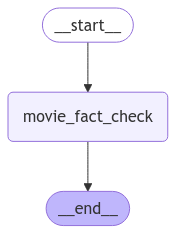

In [ ]:
movie_graph = StateGraph(OverallState, input=InputState, output=OutputState)
# movie_graph.add_node(rational_plan_node)
# movie_graph.add_node(initial_node_selection)
movie_graph.add_node(movie_fact_check)
# movie_graph.add_node(movie_check)
# movie_graph.add_node(answer_reasoning)
# movie_graph.add_node(neighbor_select)

movie_graph.add_edge(START, "movie_fact_check")
# movie_graph.add_edge("rational_plan_node", "initial_node_selection")
# movie_graph.add_edge("movie_fact_check", "movie_fact_check")
# movie_graph.add_conditional_edges(
#     "movie_fact_check",
#     movie_fact_condition,  # Updated condition function for movie context
# )
# movie_graph.add_conditional_edges(
#     "movie_check",
#     chunk_condition,  # If further conditions are needed for movie chunks
# )
# movie_graph.add_conditional_edges(
#     "neighbor_select",
#     neighbor_condition,  # For selecting neighbors in movie context
# )
movie_graph.add_edge("movie_fact_check", END)

movie_graph = movie_graph.compile()

# View
display(Image(movie_graph.get_graph().draw_mermaid_png()))


In [ ]:
facts = get_movie_facts(["Al Pacino"])
print(facts)



> Entering new FalkorDBQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
WHERE p.name = 'Al Pacino'
RETURN m.title
Full Context:
[['The Godfather'], ['The Godfather: Part II'], ['The Godfather Coda: The Death of Michael Corleone'], ['The Godfather'], ['The Godfather: Part II'], ['The Godfather Coda: The Death of Michael Corleone']]

> Finished chain.
{'query': ['Al Pacino'], 'result': 'I believe Al Pacino starred in The Godfather, The Godfather: Part II, and The Godfather Coda: The Death of Michael Corleone.'}


In [ ]:
# neighbors = get_neighbors_by_actor(["Tom Cruise"])
# print(neighbors)

In [ ]:
state = {
    "question": "Top Gun",
    # "rational_plan": "Fetch movies linked to Al Pacino.",
    # "notebook": "",
    # "previous_actions": [],
    # "check_movie_facts_queue": ["Al Pacino"],
}
response = movie_fact_check(state)
print(response)




> Entering new FalkorDBQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
WHERE m.title = 'Top Gun'
RETURN p.name
Full Context:
[['Tom Cruise'], ['Val Kilmer'], ['Anthony Edwards'], ['Meg Ryan'], ['Tom Cruise'], ['Val Kilmer'], ['Anthony Edwards'], ['Meg Ryan']]

> Finished chain.
Top Gun {'query': ['Top Gun'], 'result': 'I believe the cast of Top Gun includes Tom Cruise, Val Kilmer, Anthony Edwards, and Meg Ryan. It seems that all four of them were part of the movie.'}
--------------------
Step: movie_fact_check
Reading movie facts about: Top Gun
updated_notebook='Notebook updated with the cast of Top Gun: Tom Cruise, Val Kilmer, Anthony Edwards, and Meg Ryan.' rational_next_action='Analyze the cast of Top Gun to find relevant information.' chosen_action='read_movie'
Rational for next action after movie check: Analyze the cast of Top Gun to find relevant information.
Chosen action: {'function_name': 'read_movie', 'arguments': []}
{'notebook': 'Notebook update

In [ ]:
movie_graph.invoke({"question": "Who played in Top Gun?"})



> Entering new FalkorDBQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
WHERE m.title = 'Top Gun'
RETURN p.name
Full Context:
[['Tom Cruise'], ['Val Kilmer'], ['Anthony Edwards'], ['Meg Ryan'], ['Tom Cruise'], ['Val Kilmer'], ['Anthony Edwards'], ['Meg Ryan']]

> Finished chain.
Who played in Top Gun? {'query': ['Who played in Top Gun?'], 'result': 'Tom Cruise, Val Kilmer, and Anthony Edwards all played in Top Gun, as well as Meg Ryan.'}
--------------------
Step: movie_fact_check
Reading movie facts about: Who played in Top Gun?
updated_notebook="Previously, the notebook contained the question: 'Who played in Top Gun?'. Now, the notebook is updated with the movie's title: Top Gun." rational_next_action="The question asks for the actors in the movie Top Gun. To answer this question, we need to access the movie's details. Therefore, the chosen action is 'read_movie'." chosen_action='read_movie'
Rational for next action after movie check: The question asks for

{'previous_actions': ['movie_fact_check(None)']}